In [1]:
import os

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
%matplotlib widget

## Arbitrary sound

In [3]:
amplitude = 1
f0 = 440
sample_rate = 44100
damping = 2


def make_sound(amplitude, damping):
    times = np.linspace(0, 1, sample_rate)
    waveform = amplitude * np.exp(-damping * times) * np.cos(f0 * times)
    return waveform


waveform = make_sound(amplitude, damping)

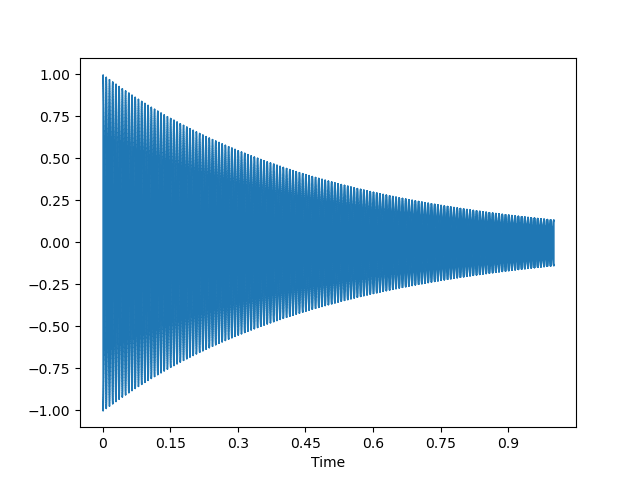

In [4]:
plt.figure()
# Display waveform
librosa.display.waveshow(waveform, sr=sample_rate)
plt.show()

## Sound/no sound criterion

In [5]:
N = len(waveform)

N2_3 = int(2 * N / 3)
criterion = np.mean(np.abs(waveform[N2_3:]))
print(criterion)


def are_there_oscillations(waveform, epsilon):
    N2_3 = int(2 * len(waveform) / 3)
    criterion = np.mean(np.abs(waveform[N2_3:]))
    return criterion > epsilon

0.12222087679658754


## Artificial map

Make dataset complete with labels

In [6]:
# Randomly sample data points (uniform distribution)
# Here we sample the amplitude and the damping factor

n_points = 100
parameters = np.random.rand(n_points, 2)
parameters[:, 1] *= 5
wave_dataset = np.zeros((n_points, sample_rate))
labels = np.zeros(n_points)

for i, x in enumerate(parameters):
    ampl, damp = x
    waveform = make_sound(ampl, damp)
    wave_dataset[i] = waveform
    labels[i] = 1 if are_there_oscillations(waveform, epsilon=0.1) else -1

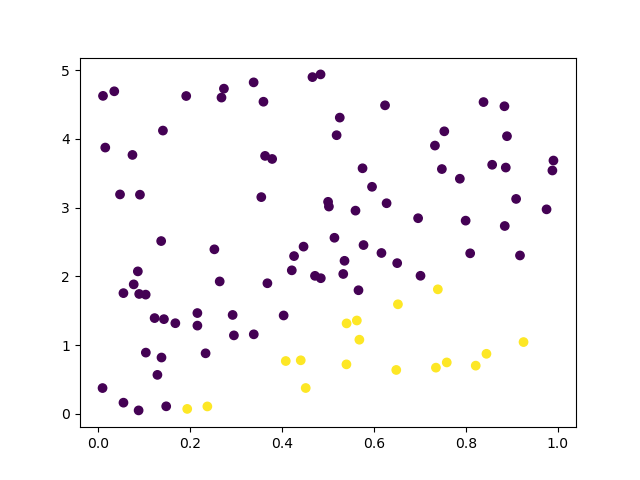

In [7]:
plt.figure()
plt.scatter(parameters[:, 0], parameters[:, 1], c=labels)
plt.show()

## Design of Experiments

In [8]:
from doepy import build

test = build.space_filling_lhs(
    {"gamma": [0, 3], "xi": [0, 1], "test": [0, 1]}, num_samples=250
)

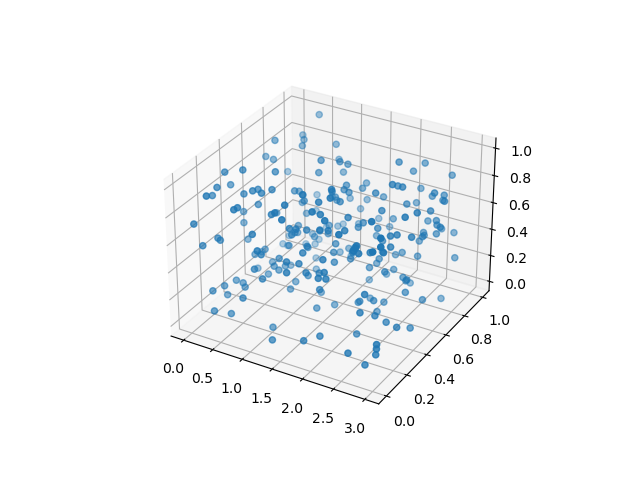

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(test["gamma"], test["xi"], test["test"])
plt.show()

## Support Vector Machine

In [10]:
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

In [11]:
model = SVC(kernel="rbf")
model.fit(parameters, labels)

SVC()

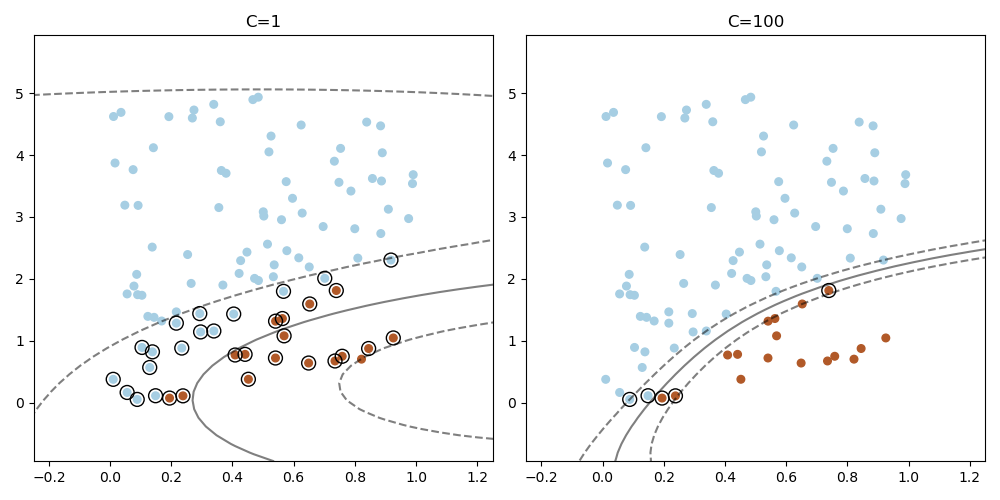

In [12]:
X, y = parameters, labels

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = SVC(C=C, random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.title("C=" + str(C))
    plt.xlim([-0.25, 1.25])
    # plt.ylim([-0.25, 10])
plt.tight_layout()
plt.show()

## Probability estimates

Probability of belonging to the positive class ie presence of sound

In [13]:
n_monte_carlo = 10000
points = np.random.rand(n_monte_carlo, 2)

indicator_function = clf.decision_function(points)
indicator_function[indicator_function < 0] = 0
indicator_function[indicator_function > 0] = 1
probability = np.sum(indicator_function)
probability /= n_monte_carlo

In [14]:
print(probability)

0.7449


## Adaptive sampling

Refinement of the SVM boundary

Idea : add samples by solving the following optimization problem

$$
\begin{align}
    \max_\mathbf{x} &||\mathbf{x} - \mathbf{x}_{nearest}|| \\
    \text{s.t. } &s(\mathbf{x}) = 0 \\
    &\mathbf{x_{min}} \leq \mathbf{x} \leq \mathbf{x}_{max}
\end{align}
$$


### Algorithm for the construction of explicit boundary
Methodology for the construction of explicit boundaries
https://codes.arizona.edu/sites/default/files/pdf/Basudhar2010a.pdf

 1. Sample the space with a CVT DOE
 2. Evaluate the system response at each sample (e.g. suing a finite element code)
 3. Classify he samples into two classes (e.g. safe and failed) based on the responses values.
 4. Set iteration k = 0
 5. Select the parameters for constructing the SVM boundary
 6. Construct the initial SVM boundary that separates the classified samples
 7. **repeat**
    * 8    k = k + 1
    * 9 Select a primary sample on the SVM bounadry and reconstruc tthe SVM with the new information
    * 10 Repeat 9 to select another primary sample
    * 11 Select a secondary sample to prevent locking of the SVM. Reconstruct the SVM boundary.
    * 12 Modify the SVM parameters if any of the training samples are misclassified. Reconstruct the SVM boundary.
    * 13 Calculate the convergence measure $\Delta_k$
 14. **Until** $\Delta_k \leq \delta_1$

In [15]:
# TODO

## Test avec un premier modèle physique
Modèle de Maganza

In [16]:
from maganza import make_sound

In [28]:
# Initial DOE: build initial parameters space
num_samples = 250
parameters = build.space_filling_lhs(
    {"gamma": [0, 1], 
     "zeta": [0, 1]},
    num_samples=num_samples
)

# Create sound samples and associated labels
wave_dataset = np.zeros((num_samples, sample_rate))
labels = np.zeros(num_samples)
for i, x in tqdm(parameters.iterrows()):
    waveform = make_sound(x["gamma"], x["zeta"])
    wave_dataset[i] = waveform
    n_1_3 = int(len(waveform)/3)
    labels[i] = np.mean(waveform[n_1_3:])
    # labels[i] = 1 if are_there_oscillations(waveform, epsilon=0.1) else -1

0it [00:00, ?it/s]

/home/leo/coding/atiam/Auto-oscillations/maganza.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  A = zeta * (3 * gamma - 1) / 2 / np.sqrt(gamma)
/home/leo/coding/atiam/Auto-oscillations/maganza.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  B = -zeta * (3 * gamma + 1) / 8 / gamma ** (3 / 2)
/home/leo/coding/atiam/Auto-oscillations/maganza.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  C = -zeta * (gamma + 1) / 16 / gamma ** (5 / 2)
/home/leo/coding/atiam/Auto-oscillations/maganza.py:48: RuntimeWarning: invalid value encountered in double_scalars
  return F0 + A * p + B * p**2 + C * p**3


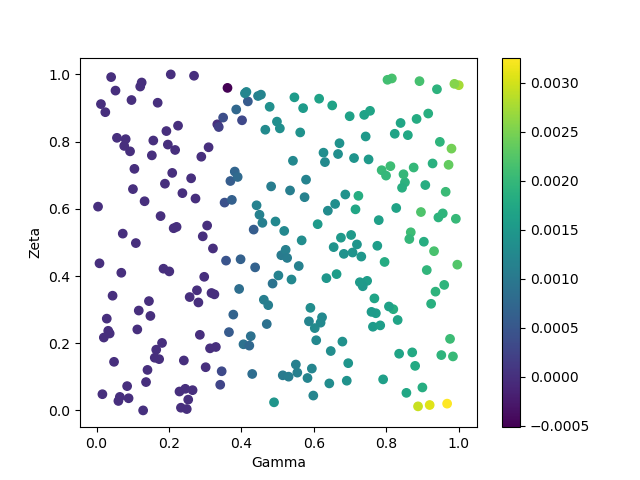

In [30]:
plt.figure()
plt.scatter(parameters["gamma"], parameters["zeta"], c=labels)
plt.xlabel("Gamma")
plt.ylabel("Zeta")
plt.colorbar()
plt.show()